# Stock prediction

In [21]:
# Imports
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

In [26]:
# Import yfinance
import yfinance as yf  

# bring data to current
import datetime
today = datetime.date.today()
start = '1995-01-03' #beginning of SPY data

# Get the data for the stock Apple by specifying 
# the stock ticker, start date, and end date
data_spy = yf.download('SPY',start, today)

# identify data that is nan
data_spy.fillna(method='ffill')
    
# renaming columns to make merging of data frames easier (later)
data_spy.columns = ['SPY_OPEN', 'SPY_HIGH', 'SPY_LOW', 'SPY_CLOSE', 'SPY_ADJ_CLOSE', 'SPY_VOLUME']

#sanity check data
data_spy.tail(10)

[*********************100%***********************]  1 of 1 downloaded


,SPY_OPEN,SPY_HIGH,SPY_LOW,SPY_CLOSE,SPY_ADJ_CLOSE,SPY_VOLUME
Date,,,,,,
2019-07-29,301.88,302.01,300.85,301.46,301.46,38126500
2019-07-30,299.91,301.17,299.49,300.72,300.72,45849000
2019-07-31,300.99,301.20,295.20,297.43,297.43,104245200
2019-08-01,297.60,300.87,293.96,294.84,294.84,142646600
2019-08-02,293.85,294.12,290.90,292.62,292.62,116749700
2019-08-05,288.09,288.21,281.72,283.82,283.82,178745400
2019-08-06,285.91,288.04,284.28,287.80,287.80,120711700
2019-08-07,284.40,288.82,282.04,287.97,287.97,140572300
2019-08-08,289.62,293.62,289.01,293.62,293.62,87713900


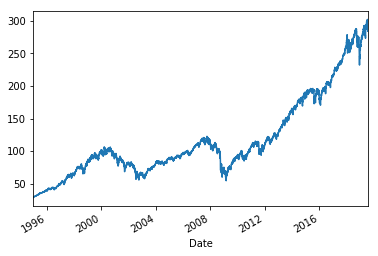

In [27]:
data_spy.SPY_ADJ_CLOSE.plot()
plt.show()

In [19]:
# cache data for later use
# identify missing data with nan for elimination later
data_spy.to_csv('data/spy.csv')

In [24]:
# read data back in - mainly for reproducibility,
# and/or not wanting to download new data...
def parse(x):
    return pd.to_datetime(x, infer_datetime_format=True)

data_spy = read_csv('data/spy.csv', date_parser=parse, index_col=0)

#sanity
data_spy.tail(10)

,SPY_OPEN,SPY_HIGH,SPY_LOW,SPY_CLOSE,SPY_ADJ_CLOSE,SPY_VOLUME
Date,,,,,,
2019-07-29,301.88,302.01,300.85,301.46,301.46,38126500
2019-07-30,299.91,301.17,299.49,300.72,300.72,45849000
2019-07-31,300.99,301.20,295.20,297.43,297.43,104245200
2019-08-01,297.60,300.87,293.96,294.84,294.84,142646600
2019-08-02,293.85,294.12,290.90,292.62,292.62,116749700
2019-08-05,288.09,288.21,281.72,283.82,283.82,178745400
2019-08-06,285.91,288.04,284.28,287.80,287.80,120711700
2019-08-07,284.40,288.82,282.04,287.97,287.97,140572300
2019-08-08,289.62,293.62,289.01,293.62,293.62,87713900


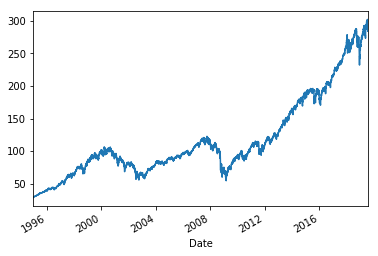

In [25]:
# sanity 
data_spy.SPY_ADJ_CLOSE.plot()
plt.show()

In [29]:
# get values for LSTM processing
values = data_spy.values
values = values.astype('float32')

In [31]:
# normalize features
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [35]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [37]:
# frame as supervised learning
supervised = series_to_supervised(scaled, 1, 1)
# drop columns that are not predicted
#supervised.drop(supervised.columns[[10,11,12,13,15,16,17,18,19]], axis=1, inplace=True)
print(supervised.tail())

# split into train and test sets
values = supervised.values

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
6190   0.968655   0.968368   0.961005   0.963353   0.965569   0.134027   
6191   0.946171   0.945318   0.925028   0.929009   0.933302   0.205204   
6192   0.937661   0.944655   0.935060   0.944542   0.947895   0.138576   
6193   0.931767   0.947697   0.926282   0.945206   0.948519   0.161378   
6194   0.952143   0.966418   0.953598   0.967256   0.969236   0.100692   

       var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
6190  0.946171  0.945318  0.925028  0.929009  0.933302  0.205204  
6191  0.937661  0.944655  0.935060  0.944542  0.947895  0.138576  
6192  0.931767  0.947697  0.926282  0.945206  0.948519  0.161378  
6193  0.952143  0.966418  0.953598  0.967256  0.969236  0.100692  
6194  0.963697  0.964936  0.956106  0.959450  0.961902  0.103261  


In [39]:
n_train_days = 252 * 20 #  252 trading days per year muliplied by X years
train = values[:n_train_days, :]
test = values[n_train_days:, :]	
print(train.shape, test.shape)

(5040, 12) (1154, 12)


In [40]:
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5040, 11) (5040,) (1154, 11) (1154,)
(5040, 1, 11) (5040,) (1154, 1, 11) (1154,)
